In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_rec = session.query(measurement.date).\
                               order_by(measurement.date.desc()).first()
most_recent_rec

('2017-08-23',)

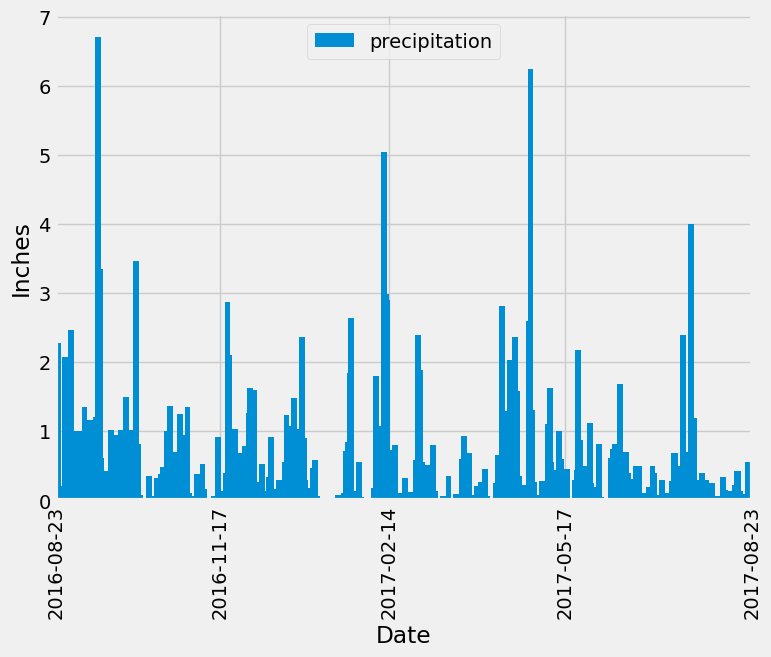

<Figure size 640x480 with 0 Axes>

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = most_recent_rec.date

# Calculate the date one year from the last date in data set.
date_one_year_back = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - pd.offsets.DateOffset(months=12)).strftime("%Y-%m-%d")

# # Perform a query to retrieve the data and precipitation scores
last_year_prcp_result = session.query(measurement.date ,measurement.prcp).\
                    filter(measurement.date >= date_one_year_back).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_prcp = pd.DataFrame(last_year_prcp_result,columns=['date', 'precipitation'])

# Sort the dataframe by date
last_year_prcp = last_year_prcp.dropna()
last_year_prcp = last_year_prcp.sort_values('date', ascending = True )

# # # Use Pandas Plotting with Matplotlib to plot the data
tick_locations = []
x_axis = last_year_prcp["date"]
y_axis = last_year_prcp["precipitation"]

tick_locations = [list(x_axis)[i] for i in range(int(len(x_axis)/4), len(x_axis) - int(len(x_axis)/4), int(len(x_axis)/4)  )]
tick_locations.append(x_axis.min())        
tick_locations.append(x_axis.max())

plt.figure(figsize = (8,6))
plt.bar(x_axis, y_axis,linewidth=2,width=3)
plt.xticks(tick_locations,  rotation = "vertical")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["precipitation"], loc='upper center')
plt.xlim(date_one_year_back, most_recent_date)
plt.grid("on")

plt.show()
plt.tight_layout()

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_prcp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query( measurement.station.label('station'), func.count(measurement.station).label('count') ).\
                                  group_by(measurement.station).\
                                  order_by(func.count().desc())
most_active_stations.all()
# print(str(most_active_stations))

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sub = most_active_stations.limit(1).subquery()
query = session.query(func.min(measurement.tobs), func.max(measurement.tobs) , func.avg(measurement.tobs)).\
                     filter(measurement.station == sub.c.station)

query.all()

[(54.0, 85.0, 71.66378066378067)]

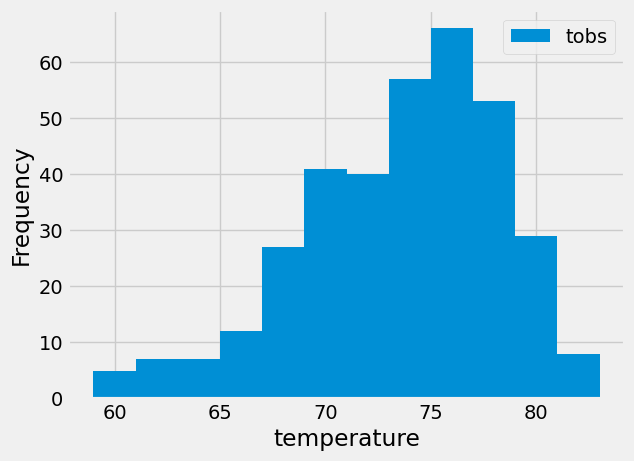

In [64]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_of_temp_observation = session.query(measurement.station,measurement.date,measurement.tobs).\
                                        filter(measurement.station == sub.c.station).\
                                        filter(measurement.date >= date_one_year_back).all()
   
# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_temp = pd.DataFrame(year_of_temp_observation,columns=['station','date', 'temperature'])

axarr = last_year_temp.hist(bins=12,column='temperature')

for ax in axarr.flatten():
    ax.set_xlabel("temperature")
    ax.set_ylabel("Frequency")
    ax.set_title("")
    ax.legend(["tobs"], loc='upper right')

# Close Session

In [65]:
# Close Session
session.close()